In [1]:
# load required packages
from keras.applications import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import *
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization
import h5py as h
import numpy as np
from PIL import Image
import seaborn as sns
from keras.utils import plot_model
import os
import glob
import shutil
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from utils import *
import graphviz
import pydot

%matplotlib inline

C:\Users\Casper\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
# path
path = 'E:/Kaggle/Catvs.Dog/train/'
test_path =  'E:/Kaggle/Catvs.Dog/test/'

In [33]:
batch_size = 16

In [36]:
#explore dataset
cat_in_train = os.listdir(os.path.join(path,'cat'))
dog_in_train = os.listdir(os.path.join(path,'dog'))
test_file = os.listdir(test_path)
print('The number of cat image in train set:',len(cat_in_train))
print('The number of dog image in train set:',len(dog_in_train))
print('The number of test image:',len(test_file))

The number of cat image in train set: 12500
The number of dog image in train set: 12500
The number of test image: 12500


In [5]:
#label = list(np.zeros(len(cat_in_train)))+list(np.ones(len(dog_in_train)))

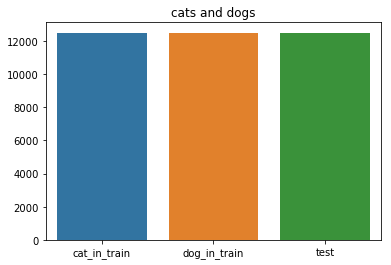

In [89]:
sns.barplot(x=['cat_in_train','dog_in_train','test'],y=[len(cat_in_train),len(dog_in_train),len(test_file)])
plt.title('cats and dogs')

In [7]:
#visualizing some samples from training data

In [8]:
shuff_cat = np.random.permutation(cat_in_train)
shuff_dog = np.random.permutation(dog_in_train)

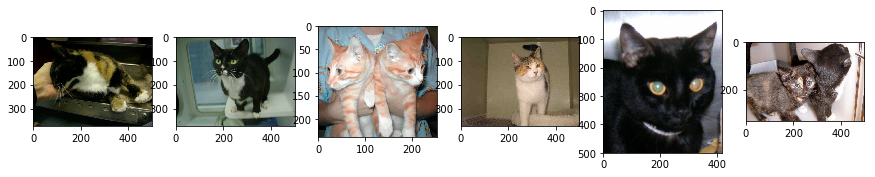

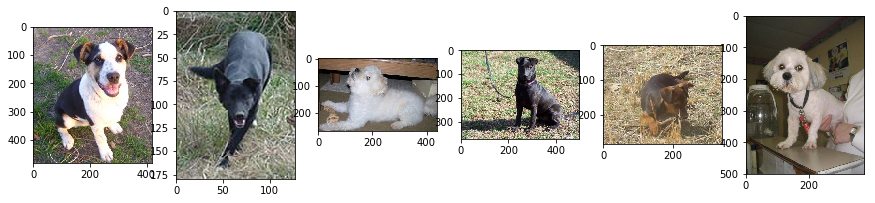

In [9]:
def plot(name,shuff):
    fig = plt.figure(figsize=(20,15))
    for i,j in enumerate(shuff[:6]):
        img = Image.open(path+name+j)
        subimg = fig.add_subplot(1,8,i+1)
        subimg.imshow(img)
   
plot('cat/',shuff_cat) 
plot('dog/',shuff_dog)

In [14]:
# Visualizing the image after preprocess

In [10]:
def load_sample(i,size=None):
    img_raw = image.load_img(path+'cat/'+shuff_cat[i],target_size=size)    
    return img_raw

def after_preprocess(img,model):
    x = model.preprocess_input(image.img_to_array(img))
    x = image.array_to_img(x)
    return x    

In [11]:
model_list = [vgg16,resnet50,xception]
names = [('vgg16',224),('resnet50',224),('xception',299)]

In [19]:
def visual_preprocess(idx):
    fig, axes = plt.subplots(figsize=(10,10),nrows=2,ncols=2)
    img_raw = load_sample(idx)
    axes[0,0].imshow(img_raw)
    axes[0,0].set_title('raw_image')
    for ax,model,(name,size) in zip(axes.flatten()[1:],model_list,names):    
        ax.imshow(after_preprocess(load_sample(idx,(size,size)),model))
        ax.set_title(name)
    fig.tight_layout(pad = 0.5,h_pad=0.1,w_pad=0.1)
    plt.show()

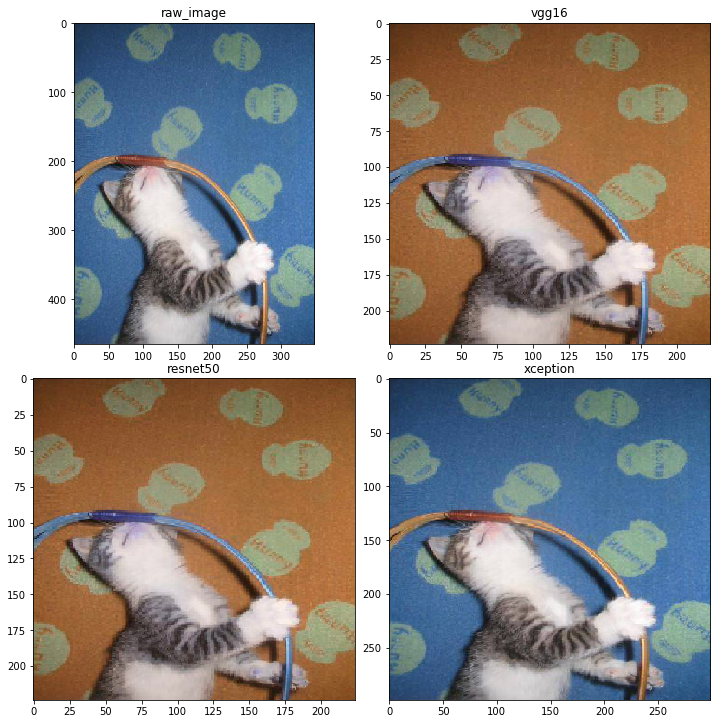

In [20]:
visual_preprocess(38)

In [41]:
# create validation directory
os.mkdir('E:/Kaggle/Catvs.Dog/valid/')

In [86]:
#collecte 2000 image and move to valid
filenames = cat_in_train + dog_in_train
valid = np.random.permutation(filenames)[:2000]
#train,valid = train_test_split(filenames,test_size=0.1)

In [87]:
val_cat = [x for x in valid if 'cat' in x]
val_dog = [x for x in valid if 'dog' in x]

cat in valid 998
dog in valid 1002


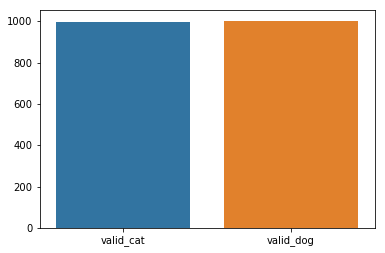

In [88]:
sns.barplot(x=['valid_cat','valid_dog'],y=[len(val_cat),len(val_dog)])
print('cat in valid',len(val_cat))
print('dog in valid',len(val_dog))

In [2]:
base_model  = VGG16(input_shape = (224,224,3))

In [3]:
base_model.layers.pop()

In [4]:
base_model.outputs = base_model.layers[-1].output

In [5]:
x = base_model.outputs
pred = Dense(2,activation='softmax')(x)
vgg_model = Model(inputs = base_model.input,outputs=pred)


In [6]:
vgg_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
plot_model(vgg_model,rankdir='TB',show_shapes = True)

In [16]:
base_model = ResNet50(input_shape = (224,224,3),include_top=False,pooling = 'avg')

94658560/94653016 [==============================] - 121s 1us/step


In [18]:
x = base_model.output
x = Dropout(0.5)(x)
pred = Dense(2,activation='softmax')(x)
res_model = Model(inputs=base_model.input,outputs=pred)

In [20]:
plot_model(res_model,rankdir='TB',show_shapes=True)

In [34]:
sample_path = 'E:\Kaggle\Catvs.Dog\sample'

In [137]:
# data augmentation
args_list=[ dict(zoom_range = 0.3), #0.2,0.3
               dict(rotation_range = 20), 
                dict(shear_range = 0.2),
             dict(width_shift_range = 0.2),
          dict(height_shift_range = 0.2),
             dict(horizontal_flip = True),
           ]
            

In [138]:
def augmentation(args):
    arg_gen = ImageDataGenerator(**args)
    sample_gen = arg_gen.flow_from_directory(sample_path,target_size=[224,224],batch_size = 1)
    return sample_gen.next()[0][0]

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


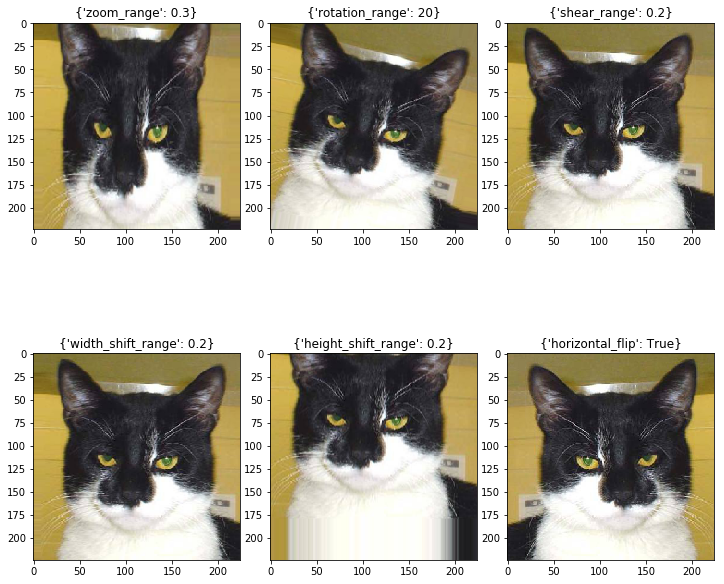

In [139]:
fig, axes = plt.subplots(figsize=(10,10),nrows=2,ncols=3)
for ax,i in zip(axes.flatten(),args_list):
    ax.imshow(image.array_to_img(augmentation(i)))
    ax.set_title(str(i))
fig.tight_layout(pad = 0.5,h_pad=0.1,w_pad=0.1)